In [1]:
# ACQUIRE
import numpy as np
import pandas as pd
import unicodedata
import re
import nltk

import warnings
warnings.filterwarnings('ignore')

# PREPARE
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import prepare
from sklearn.model_selection import train_test_split
# nltk.download('wordnet') - needed to run to download 'wordnet' resource to use lemmatize function

# EXPLORE
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats

# MODELING
from numpy.random import choice
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# EVALUATION
from sklearn.metrics import classification_report, accuracy_score

In [2]:
df = pd.read_json('data.json')
df

,repo,language,readme_contents
0,gocodeup/codeup-setup-script,Shell,# Codeup Setup Script\n\nSetup script for Code...
1,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w..."
2,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...
3,beetbox/beets,Python,.. image:: https://img.shields.io/pypi/v/beets...
4,scottschiller/SoundManager2,JavaScript,# SoundManager 2: JavaScript Sound for the Web...
...,...,...,...
197,andyxialm/CutoLoadingView,Java,#CutoLoadingView\n[![](https://jitpack.io/v/an...
198,rjsvieira/morphos,Java,# Morphos\n\n![Current Version](https://img.sh...
199,tuesda/SubmitDemo,Java,This is library project with a custom view tha...
200,avenwu/support,Java,Support\n========\n\nCustom Android support li...


In [3]:
df = prepare.prep_data(df, 'readme_contents')

In [4]:
df

,repo,language,readme_contents,stemmed,lemmatized,clean,stopwords_removed,doc_length,words
0,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w...",movi applic for thi project we will be build a...,movie application for this project we will be ...,movie application building single page movie a...,386,406,"[movie, application, building, single, page, m..."
1,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...,linux kernel there are sever guid for kernel d...,linux kernel there are several guide for kerne...,linux kernel several guide kernel developer us...,45,65,"[linux, kernel, several, guide, kernel, develo..."
2,beetbox/beets,Python,.. image:: https://img.shields.io/pypi/v/beets...,imag http img shield io pypi v beet svg target...,image http img shield io pypi v beet svg targe...,image img shield io pypi v beet svg target pyp...,274,455,"[image, img, shield, io, pypi, v, beet, svg, t..."
3,scottschiller/SoundManager2,JavaScript,# SoundManager 2: JavaScript Sound for the Web...,soundmanag javascript sound for the web by wra...,soundmanager javascript sound for the web by w...,soundmanager javascript sound web wrapping ext...,339,615,"[soundmanager, javascript, sound, web, wrappin..."
4,CreateJS/SoundJS,JavaScript,# SoundJS\r\n\r\nSoundJS is a library to make ...,soundj soundj is a librari to make work with a...,soundjs soundjs is a library to make working w...,soundjs soundjs make working audio web easier ...,198,314,"[soundjs, soundjs, make, working, audio, web, ..."
...,...,...,...,...,...,...,...,...,...
180,andyxialm/CutoLoadingView,Java,#CutoLoadingView\n[![](https://jitpack.io/v/an...,cutoloadingview http jitpack io v andyxialm cu...,cutoloadingview http jitpack io v andyxialm cu...,cutoloadingview jitpack io v andyxialm cutoloa...,78,132,"[cutoloadingview, jitpack, io, v, andyxialm, c..."
181,rjsvieira/morphos,Java,# Morphos\n\n![Current Version](https://img.sh...,morpho current version http img shield io badg...,morphos current version http img shield io bad...,morphos current version img shield io badge cu...,209,674,"[morphos, current, version, img, shield, io, b..."
182,tuesda/SubmitDemo,Java,This is library project with a custom view tha...,thi is librari project with a custom view that...,this is library project with a custom view tha...,custom view implement concept submit button dr...,17,92,"[custom, view, implement, concept, submit, but..."
183,avenwu/support,Java,Support\n========\n\nCustom Android support li...,support custom android support librari includ ...,support custom android support library include...,support custom android support include useful ...,97,261,"[support, custom, android, support, include, u..."


In [5]:
df.language.value_counts()

HTML                30
Ruby                28
JavaScript          28
C++                 28
Python              28
Java                24
Jupyter Notebook     6
CSS                  4
TypeScript           3
C                    2
C#                   2
Scala                2
Name: language, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   repo               185 non-null    object
 1   language           185 non-null    object
 2   readme_contents    185 non-null    object
 3   stemmed            185 non-null    object
 4   lemmatized         185 non-null    object
 5   clean              185 non-null    object
 6   stopwords_removed  185 non-null    int64 
 7   doc_length         185 non-null    int64 
 8   words              185 non-null    object
dtypes: int64(2), object(7)
memory usage: 13.1+ KB


In [9]:
train_validate, test = train_test_split(df, stratify = df.language, test_size = .15, random_state= 123)
train, validate = train_test_split(train_validate, stratify = train_validate.language, test_size = .20, random_state = 123)

In [10]:
train.shape, validate.shape, test.shape

((125, 9), (32, 9), (28, 9))

In [11]:
train.language.value_counts()

HTML                20
C++                 19
Python              19
Ruby                19
JavaScript          19
Java                16
Jupyter Notebook     4
C#                   2
TypeScript           2
CSS                  2
C                    2
Scala                1
Name: language, dtype: int64

In [12]:
validate.shape

(32, 9)

In [13]:
validate.language.value_counts()

HTML                5
C++                 5
Ruby                5
JavaScript          5
Python              5
Java                4
CSS                 1
Jupyter Notebook    1
Scala               1
Name: language, dtype: int64

In [14]:
# create series objects for each top_code_clean that is a string of words joined on spaces to make it 1 continious string  
javascript_words = ' '.join(train[train.language=='JavaScript'].clean)
python_words = ' '.join(train[train.language=='Python'].clean)
ruby_words = ' '.join(train[train.language=='Ruby'].clean)
html_words = ' '.join(train[train.language=='HTML'].clean)
c_plus_plus_words = ' '.join(train[train.language=='C++'].clean)
all_words = ' '.join(train.clean)

# Exploration

Explore the data that you have scraped. Here are some ideas for exploration:

- What are the most common words in READMEs?
- What does the distribution of IDFs look like for the most common words?
- Does the length of the README vary by programming language?
- Do different programming languages use a different number of unique words?

### What are the most common words in READMEs?

In [15]:
all_words_df = pd.DataFrame(all_words.split())

In [16]:
all_words_df.value_counts().head(10)

learning      545
data          506
machine       462
python        345
html          307
code          268
build         252
tensorflow    248
io            239
j             232
dtype: int64

### What does the distribution of IDFs look like for the most common words?

In [17]:
def idf(words_df):
    '''
    Takes in a dataframe made of a single column where each row is a single word and 
    returns a dataframe containing the top 10 most frequent words,
    the number of documents each word shows up in, and the idf value for each word
    '''
    
    # Creates a dictionary of the top ten words and their number of counts
    top_10_words = words_df[0].value_counts(dropna=False).head(10).keys().tolist()
    top_10_counts = words_df[0].value_counts(dropna=False).head(10).tolist()
    word_counts = dict(zip(top_10_words, top_10_counts))
    
    # Derives the 10 most common words from the given dataframe of words
    most_common_words = [word[0] for word in list(words_df.value_counts().head(10).index)]
    
    # This dictionary will store how many documents each word appears in 
    appearances_dict = dict.fromkeys(most_common_words)
    
    # The total number of documents is based on the number of rows in the train dataframe
    number_of_documents = train.shape[0]
    
    # This is essentially a list containing the contents of the words column in the dataframe. It is a list of lists.
    list_of_wordlists = list(train.words.values)
    
    # Start iterating through the list of common words. We want to collect information for each one.
    for word in most_common_words:
        
        # Set the initial number of documents that the word appears in to zero
        number_of_appearances = 0
        
        # Start iterating through the list made from the words column in the dataframe 
        for words in list_of_wordlists:
            
            # If the current word is in a document, add 1 to the number of appearances and then move to the next document
            if word in words:
                number_of_appearances += 1
        
        # Once all the documents have been iterated through, add the sum total of all appearances to our appearances dictionary
        appearances_dict[word] = number_of_appearances
        
    # Create a new dictionary that will contain the IDF values for each word
    idf_dict = dict.fromkeys(most_common_words)
    
    # Start iterating through the list of common words again, using the number of appearances and the total number of documents to calculate the IDF and update the relevant key:value in the dictionary
    for word in most_common_words:
        idf_dict[word] = np.log(number_of_documents / appearances_dict[word])
    
    # Create dataframes containing the information of the total counts, the number of documents, and the idf value
    idf_df1 = pd.DataFrame.from_dict(word_counts, orient='index', columns=['total_count']).reset_index().rename(columns={'index':'word'})
    idf_df2 = pd.DataFrame.from_dict(appearances_dict, orient='index', columns=['num_of_documents']).reset_index().rename(columns={'index':'word'})
    idf_df3 = pd.DataFrame.from_dict(idf_dict, orient='index', columns=['idf_value']).reset_index().rename(columns={'index':'word'})
    
    # Merge the dataframes into a single dataframe
    idf_df = pd.merge(idf_df1, idf_df2, left_on = 'word', right_on = 'word')
    idf_df = pd.merge(idf_df, idf_df3, left_on = 'word', right_on = 'word')
    
    # Return the dataframe
    return idf_df

In [18]:
idf(all_words_df)

,word,total_count,num_of_documents,idf_value
0,learning,545,15,2.120264
1,data,506,38,1.190728
2,machine,462,20,1.832581
3,python,345,28,1.496109
4,html,307,52,0.877070
5,code,268,66,0.638659
6,build,252,52,0.877070
7,tensorflow,248,5,3.218876
8,io,239,53,0.858022
9,j,232,26,1.570217


### Does the length of the README vary by programming language?

In [19]:
train.groupby('language').doc_length.mean().sort_values(ascending=False)

language
TypeScript          2227.500000
Python              1585.368421
Ruby                 450.578947
C++                  396.894737
C#                   395.000000
JavaScript           343.789474
Java                 286.750000
Scala                283.000000
HTML                 265.800000
C                    210.000000
CSS                  170.000000
Jupyter Notebook     106.750000
Name: doc_length, dtype: float64

In [20]:
def t_test_loop(target, alpha = 0.05):    
    '''
    This function is dependent on a globally defined dataframe named 'train' that contains a 'language' column containing strings
    The target is the header for the column being investigated. The column being investigated must be a numeric type.
    Comparative t-tests are run on the target column between every possible pair of languages represented in the train dataset.
    The function prints out the result of every t-test that has a p-value below alpha. 
    '''
    # Start by developing two identical lists of all of the languages represented in the train dataset
    # We will use the series above to form our list so our output is arranged in a similar order
    # When this is converted to a function, we can generate the list in a more generalized manner
    train_language_list_1 = list(train.groupby('language')[target].mean().sort_values(ascending=False).index)
    train_language_list_2 = list(train.groupby('language')[target].mean().sort_values(ascending=False).index)

    # This empty list will hold information about which pairs have been tested. 
    # If the python and javascript pair has already be tested, then we do not need to test the javascript and python pair
    testing_pairs = []

    for language_1 in train_language_list_1: # Iterates through list 1
        for language_2 in train_language_list_2: # Iterates through list 2 in entirety for each element in list 1

            if language_1 == language_2: # Cannot run a t-test against itself, so skip the test if the two list elements are identical
                continue

            else:
                alpha = 0.05 # Set alpha

                # Run the t-test and store the t-statistic and the p-value
                stat, p = stats.ttest_ind(train[train.language == language_1][target], train[train.language == language_2][target])

                # If the p-value is statistically significant we print the results, otherwise we do nothing
                if p/2 < alpha:

                    # Creating strings to represent the pair that is being tested (eg. 'Python and JavaScript' & 'JavaScript and Python')
                    testing_pair_1 = language_1 + " " + language_2
                    testing_pair_2 = language_2 + " " + language_1

                    # If this unique pair has not yet been tested:
                    if (testing_pair_1 not in testing_pairs) and (testing_pair_2 not in testing_pairs):

                        # Add this pair to the testing_pairs list so that we do not output duplicate t-test results
                        testing_pairs.append(testing_pair_1)
                        testing_pairs.append(testing_pair_2)

                        # Print the results of the test
                        print("----------------")
                        print(f"{target} T-Test: {language_1} & {language_2}")
                        print("----------------")
                        print("Hypotheses:")
                        print(f"H_0: There is no difference in the mean {target} of {language_1} and {language_2}")
                        print(f"H_a: There is a difference in the mean {target} of {language_1} and {language_2}")
                        print('\n')
                        print(f"p-value: {p/2}")
                        print(f"t-statistic: {stat}")
                        print(f"We reject the null hypothesis")
                        print("\n")
                        if stat < 0:
                            print(f"The mean readme {target} for {language_1} is smaller than {language_2}")
                        elif stat > 0:
                            print(f"The mean readme {target} for {language_1} is larger than {language_2}")
                        print('\n','\n')

                        # If the pair had already been tested, do not print any results and continue through the loop
                    else:
                        continue

In [21]:
t_test_loop('doc_length')

----------------
doc_length T-Test: TypeScript & Ruby
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of TypeScript and Ruby
H_a: There is a difference in the mean doc_length of TypeScript and Ruby


p-value: 0.0018824887340140337
t-statistic: 3.3000440250787317
We reject the null hypothesis


The mean readme doc_length for TypeScript is larger than Ruby

 

----------------
doc_length T-Test: TypeScript & C++
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of TypeScript and C++
H_a: There is a difference in the mean doc_length of TypeScript and C++


p-value: 0.001967416577897316
t-statistic: 3.2804469201019173
We reject the null hypothesis


The mean readme doc_length for TypeScript is larger than C++

 

----------------
doc_length T-Test: TypeScript & JavaScript
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of TypeScript and JavaScript
H_a: There is a difference in the mean doc_length 

### Do different programming languages use a different number of unique words?

In [22]:
unique_word_count = {}

train_language_list = list(train.groupby('language')['doc_length'].mean().sort_values(ascending=False).index)

for language in train_language_list:
    unique_word_count[language] = len(set(' '.join(train[train.language==language].clean).split()))

In [23]:
unique_word_count = pd.DataFrame.from_dict(unique_word_count, orient='index').rename(columns={0: 'num_unique_words'})

In [24]:
unique_word_count.sort_values(by='num_unique_words', ascending=False)

,num_unique_words
Python,6144
Ruby,2257
C++,2109
JavaScript,1973
HTML,1656
TypeScript,1289
Java,1278
C#,339
Jupyter Notebook,267
C,223


While this gives us a total count of the number of unique words each programming language has connected to it, this is likely to be correlated both to the total document length AND the number of observations that each language has. Languages with more observations likely have more opportunities to expand the unique word list. 

A better metric would be the average number of unique words that each language has. To do this we will need to add a column to our dataframe.

In [25]:
train['unique_word_count'] = train.words.apply(lambda x: len(set(x)))

In [26]:
train

,repo,language,readme_contents,stemmed,lemmatized,clean,stopwords_removed,doc_length,words,unique_word_count
26,censusreporter/censusreporter,HTML,About Census Reporter\n=====================\n...,about censu report the unit state censu bureau...,about census reporter the united state census ...,census reporter united state census bureau pro...,1573,2789,"[census, reporter, united, state, census, bure...",861
135,StarterSquad/ngseed,HTML,ngseed\n======\n\nAngularJS/RequireJS seed pro...,ngseed angularj requirej seed project document...,ngseed angularjs requirejs seed project docume...,ngseed angularjs requirejs seed documentation ...,115,265,"[ngseed, angularjs, requirejs, seed, documenta...",143
77,igrigorik/decisiontree,Ruby,# Decision Tree\n\nA Ruby library which implem...,decis tree a rubi librari which implement id3 ...,decision tree a ruby library which implement i...,decision tree ruby implement id3 information g...,101,264,"[decision, tree, ruby, implement, id3, informa...",131
84,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www....",div align center img src http www tensorflow o...,div align center img src http www tensorflow o...,div align center img src tensorflow image tf l...,513,1586,"[div, align, center, img, src, tensorflow, ima...",324
1,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...,linux kernel there are sever guid for kernel d...,linux kernel there are several guide for kerne...,linux kernel several guide kernel developer us...,45,65,"[linux, kernel, several, guide, kernel, develo...",47
...,...,...,...,...,...,...,...,...,...,...
16,designmodo/Flat-UI,JavaScript,\n# [Flat UI Free](https://designmodo.github.i...,flat ui free http designmodo github io flat ui...,flat ui free http designmodo github io flat ui...,flat ui free designmodo io flat ui flat ui bea...,219,392,"[flat, ui, free, designmodo, io, flat, ui, fla...",179
5,musescore/MuseScore,C++,![MuseScore](mscore/data/musescore_logo_full.p...,musescor mscore data musescor logo full png mu...,musescore mscore data musescore logo full png ...,musescore mscore data musescore logo full png ...,279,583,"[musescore, mscore, data, musescore, logo, ful...",311
48,Hextris/hextris,JavaScript,"Hextris\n==========\n\n<img src=""images/twitte...",hextri img src imag twitter opengraph png widt...,hextris img src image twitter opengraph png wi...,hextris img src image twitter opengraph png wi...,117,148,"[hextris, img, src, image, twitter, opengraph,...",103
147,patriciogonzalezvivo/KinectCoreVision,C++,"<iframe class=""roundPhoto"" src=""http://player....",ifram class roundphoto src http player vimeo c...,iframe class roundphoto src http player vimeo ...,iframe class roundphoto src player vimeo video...,57,127,"[iframe, class, roundphoto, src, player, vimeo...",88


Now we can run a similar set of t-tests to compare the unique word count for each programming language

In [27]:
train.groupby('language').unique_word_count.mean().sort_values(ascending=False)

language
TypeScript          672.500000
Python              480.368421
Ruby                207.473684
C#                  187.000000
JavaScript          179.421053
C++                 169.947368
Scala               151.000000
Java                129.562500
C                   120.500000
HTML                118.300000
CSS                 102.500000
Jupyter Notebook     71.500000
Name: unique_word_count, dtype: float64

In [28]:
t_test_loop('unique_word_count')

----------------
unique_word_count T-Test: TypeScript & Ruby
----------------
Hypotheses:
H_0: There is no difference in the mean unique_word_count of TypeScript and Ruby
H_a: There is a difference in the mean unique_word_count of TypeScript and Ruby


p-value: 0.006524370238190248
t-statistic: 2.7387672495326547
We reject the null hypothesis


The mean readme unique_word_count for TypeScript is larger than Ruby

 

----------------
unique_word_count T-Test: TypeScript & JavaScript
----------------
Hypotheses:
H_0: There is no difference in the mean unique_word_count of TypeScript and JavaScript
H_a: There is a difference in the mean unique_word_count of TypeScript and JavaScript


p-value: 0.0026118583716749164
t-statistic: 3.1541604406775816
We reject the null hypothesis


The mean readme unique_word_count for TypeScript is larger than JavaScript

 

----------------
unique_word_count T-Test: TypeScript & C++
----------------
Hypotheses:
H_0: There is no difference in the mean unique

# Model

In [29]:
tfidf = TfidfVectorizer()
tfidf

TfidfVectorizer()

In [30]:
# X_train, X_validate, X_test are transformed to sparse array representing TF-IDF values for every word

X_train = tfidf.fit_transform(train.clean)

X_validate = tfidf.transform(validate.clean)

X_test = tfidf.transform(test.clean)

In [31]:
# y_train, y_validate, y_test are simply the actual language labels

y_train = train.language
y_validate = validate.language
y_test = test.language

## Baseline

We will create two baseline models. 

The first will predict a language at random using weighted probabilities based on the distribution of the languages in the train dataset. 

The second will be based on the most common language in the train dataset.

### Random Baseline Model

In [32]:
def baseline_language_model(train, num_observations):
    '''
    This function takes in a train dataset and identifies the proportions for the languages represented in that set.
    It then creates an array num_observations long where each element is one of the languages randomly selected (weighted by the languages proportion)
    The array is returned to be used as a series of predictions to compare other models against.
    '''
    possible_languages = list(train.language.value_counts().index)
    probabilities = []
    for language in possible_languages:
        probabilities.append(train.language.value_counts()[language] / train.language.shape[0])
    baseline_predictions = choice(possible_languages, num_observations, p=probabilities)
    return baseline_predictions

In [33]:
baseline_train_pred_random = baseline_language_model(train, num_observations = train.language.shape[0])
baseline_train_pred_random[:10]

array(['Jupyter Notebook', 'Ruby', 'Python', 'Java', 'Java', 'Python',
       'HTML', 'C++', 'Python', 'HTML'], dtype='<U16')

In [34]:
train_results = pd.DataFrame(dict(actual=y_train))
train_results['base_random'] = baseline_train_pred_random
train_results

,actual,base_random
26,HTML,Jupyter Notebook
135,HTML,Ruby
77,Ruby,Python
84,C++,Java
1,C,Java
...,...,...
16,JavaScript,CSS
5,C++,Python
48,JavaScript,Python
147,C++,Ruby


In [35]:
print('Baseline Model: Weighted Random Selection')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.base_random)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.base_random, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.base_random))

Baseline Model: Weighted Random Selection
Accuracy: 15.20%
---
Confusion Matrix
actual            C  C#  C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  \
base_random                                                                   
C                 0   0    1    0     0     0           1                 0   
C#                0   0    1    0     0     0           0                 0   
C++               0   0    0    1     3     5           3                 1   
CSS               0   0    0    0     2     0           1                 0   
HTML              0   1    3    0     4     2           2                 0   
Java              1   0    4    1     0     3           2                 0   
JavaScript        0   0    3    0     3     3           3                 0   
Jupyter Notebook  0   0    1    0     1     0           1                 0   
Python            0   1    5    0     2     1           4                 1   
Ruby              1   0    1    0     5     2      

### Baseline Model: Mode Selection

In [36]:
train_results['base_mode'] = train.language.value_counts().idxmax()
train_results

,actual,base_random,base_mode
26,HTML,Jupyter Notebook,HTML
135,HTML,Ruby,HTML
77,Ruby,Python,HTML
84,C++,Java,HTML
1,C,Java,HTML
...,...,...,...
16,JavaScript,CSS,HTML
5,C++,Python,HTML
48,JavaScript,Python,HTML
147,C++,Ruby,HTML


In [37]:
print('Baseline Model: Mode Selection')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.base_mode)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.base_mode, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.base_mode))

Baseline Model: Mode Selection
Accuracy: 16.00%
---
Confusion Matrix
actual     C  C#  C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
base_mode                                                                      
HTML       2   2   19    2    20    16          19                 4      19   

actual     Ruby  Scala  TypeScript  
base_mode                           
HTML         19      1           2  
---
                  precision    recall  f1-score   support

               C       0.00      0.00      0.00         2
              C#       0.00      0.00      0.00         2
             C++       0.00      0.00      0.00        19
             CSS       0.00      0.00      0.00         2
            HTML       0.16      1.00      0.28        20
            Java       0.00      0.00      0.00        16
      JavaScript       0.00      0.00      0.00        19
Jupyter Notebook       0.00      0.00      0.00         4
          Python       0.00      0.00      0.00     

## Logistic Regression

In [38]:
lm = LogisticRegression().fit(X_train, y_train)

In [39]:
train_results['lm_predicted'] = lm.predict(X_train)
train_results

,actual,base_random,base_mode,lm_predicted
26,HTML,Jupyter Notebook,HTML,HTML
135,HTML,Ruby,HTML,HTML
77,Ruby,Python,HTML,Ruby
84,C++,Java,HTML,C++
1,C,Java,HTML,Python
...,...,...,...,...
16,JavaScript,CSS,HTML,JavaScript
5,C++,Python,HTML,C++
48,JavaScript,Python,HTML,JavaScript
147,C++,Ruby,HTML,C++


In [40]:
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.lm_predicted, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.lm_predicted))

Accuracy: 89.60%
---
Confusion Matrix
actual        C  C#  C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  \
lm_predicted                                                              
C++           1   0   19    0     0     0           0                 1   
HTML          0   2    0    1    20     0           0                 0   
Java          0   0    0    0     0    16           0                 0   
JavaScript    0   0    0    1     0     0          19                 0   
Python        1   0    0    0     0     0           0                 2   
Ruby          0   0    0    0     0     0           0                 1   

actual        Python  Ruby  Scala  TypeScript  
lm_predicted                                   
C++                0     0      0           0  
HTML               0     0      1           0  
Java               0     0      0           0  
JavaScript         0     0      0           2  
Python            19     0      0           0  
Ruby               0    1

## Decision Tree

In [41]:
clf = DecisionTreeClassifier(max_depth = 15, random_state = 123).fit(X_train, y_train)

In [42]:
clf_pred = clf.predict(X_train)
clf_pred[:10]

array(['HTML', 'HTML', 'Ruby', 'C++', 'C', 'HTML', 'C++', 'Java',
       'TypeScript', 'Ruby'], dtype=object)

In [43]:
train_results['clf_predicted'] = clf_pred
train_results

,actual,base_random,base_mode,lm_predicted,clf_predicted
26,HTML,Jupyter Notebook,HTML,HTML,HTML
135,HTML,Ruby,HTML,HTML,HTML
77,Ruby,Python,HTML,Ruby,Ruby
84,C++,Java,HTML,C++,C++
1,C,Java,HTML,Python,C
...,...,...,...,...,...
16,JavaScript,CSS,HTML,JavaScript,JavaScript
5,C++,Python,HTML,C++,C++
48,JavaScript,Python,HTML,JavaScript,JavaScript
147,C++,Ruby,HTML,C++,C++


In [44]:
print('Decision Tree Model')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.clf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.clf_predicted, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.clf_predicted))

Decision Tree Model
Accuracy: 94.40%
---
Confusion Matrix
actual            C  C#  C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  \
clf_predicted                                                                 
C                 2   0    0    0     0     0           0                 0   
C#                0   2    0    0     0     0           0                 0   
C++               0   0   17    0     0     0           0                 0   
CSS               0   0    0    2     0     0           0                 1   
HTML              0   0    2    0    20     0           0                 2   
Java              0   0    0    0     0    16           0                 0   
JavaScript        0   0    0    0     0     0          19                 0   
Jupyter Notebook  0   0    0    0     0     0           0                 1   
Python            0   0    0    0     0     0           0                 0   
Ruby              0   0    0    0     0     0           0                

## Random Forest

In [45]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123).fit(X_train, y_train)

In [46]:
rf_pred = rf.predict(X_train)
rf_pred[:10]

array(['HTML', 'HTML', 'Ruby', 'C++', 'HTML', 'HTML', 'Python', 'Java',
       'Python', 'Ruby'], dtype=object)

In [47]:
train_results['rf_predicted'] = rf_pred

In [48]:
print('Random Forest Model')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.rf_predicted, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.rf_predicted))

Random Forest Model
Accuracy: 80.00%
---
Confusion Matrix
actual        C  C#  C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  \
rf_predicted                                                              
C++           0   0   13    0     0     0           0                 0   
HTML          1   2    5    2    19     1           4                 3   
Java          0   0    0    0     1    15           0                 0   
JavaScript    1   0    0    0     0     0          15                 0   
Python        0   0    1    0     0     0           0                 1   
Ruby          0   0    0    0     0     0           0                 0   

actual        Python  Ruby  Scala  TypeScript  
rf_predicted                                   
C++                0     0      0           0  
HTML               0     0      0           0  
Java               0     0      0           0  
JavaScript         0     0      1           1  
Python            19     0      0           1  
Ruby 

## K-Nearest Neighbors

In [49]:
error_rate = []
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

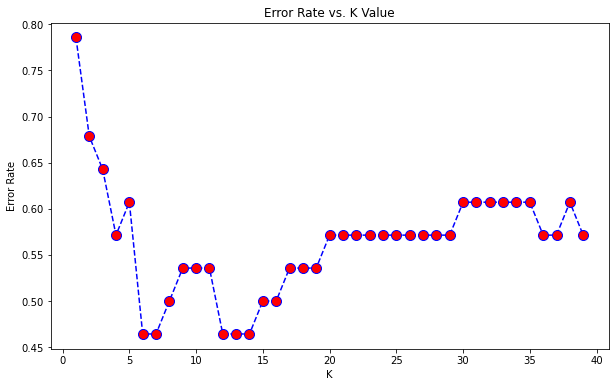

In [50]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [51]:
knn = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
knn_pred = knn.predict(X_train)
knn_pred[:10]

array(['HTML', 'JavaScript', 'Ruby', 'C++', 'Ruby', 'Python',
       'JavaScript', 'Java', 'JavaScript', 'Ruby'], dtype=object)

In [52]:
train_results['knn_predicted'] = knn_pred
train_results

,actual,base_random,base_mode,lm_predicted,clf_predicted,rf_predicted,knn_predicted
26,HTML,Jupyter Notebook,HTML,HTML,HTML,HTML,HTML
135,HTML,Ruby,HTML,HTML,HTML,HTML,JavaScript
77,Ruby,Python,HTML,Ruby,Ruby,Ruby,Ruby
84,C++,Java,HTML,C++,C++,C++,C++
1,C,Java,HTML,Python,C,HTML,Ruby
...,...,...,...,...,...,...,...
16,JavaScript,CSS,HTML,JavaScript,JavaScript,JavaScript,JavaScript
5,C++,Python,HTML,C++,C++,C++,C++
48,JavaScript,Python,HTML,JavaScript,JavaScript,JavaScript,C++
147,C++,Ruby,HTML,C++,C++,C++,C++


In [53]:
print('K-Nearest Neighbors Model')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.knn_predicted, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.knn_predicted))

K-Nearest Neighbors Model
Accuracy: 64.00%
---
Confusion Matrix
actual            C  C#  C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  \
knn_predicted                                                                 
C++               1   0   13    0     0     0           1                 0   
HTML              0   1    0    2    11     0           2                 1   
Java              0   0    2    0     1    14           0                 0   
JavaScript        0   0    2    0     5     0          14                 0   
Jupyter Notebook  0   0    0    0     0     0           0                 0   
Python            0   0    1    0     0     0           0                 3   
Ruby              1   1    1    0     3     2           2                 0   

actual            Python  Ruby  Scala  TypeScript  
knn_predicted                                      
C++                    3     0      0           0  
HTML                   1     0      0           0  
Java            

## Validation - Checking for Overfitting

We will check the following models for overfitting:
1) Baseline Random Weighted Choice  
2) Baseline Mode  
3) Logistic Regression  
4) Decision Tree  
5) Random Forest  

### Baseline Random Weighted Choice Performance on Validate

In [54]:
validate_results = pd.DataFrame(dict(actual=y_validate))

In [55]:
baseline_validate_pred_random = baseline_language_model(train, num_observations = validate.language.shape[0])
baseline_validate_pred_random[:10]

array(['TypeScript', 'Ruby', 'Python', 'Python', 'JavaScript', 'HTML',
       'Ruby', 'Ruby', 'C++', 'C++'], dtype='<U16')

In [56]:
validate_results['base_random'] = baseline_validate_pred_random
validate_results.head()

,actual,base_random
100,Python,TypeScript
126,HTML,Ruby
183,Java,Python
98,Python,Python
20,CSS,JavaScript


In [57]:
print('Baseline Model: Weighted Random Selection - VALIDATE SET')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.base_random)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.base_random, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.base_random))

Baseline Model: Weighted Random Selection - VALIDATE SET
Accuracy: 15.62%
---
Confusion Matrix
actual       C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  Ruby  \
base_random                                                                     
C#             0    0     0     0           0                 0       0     1   
C++            1    0     1     0           1                 0       0     0   
CSS            2    0     0     0           0                 0       0     0   
HTML           1    0     1     0           1                 0       1     1   
Java           0    0     0     0           2                 0       0     1   
JavaScript     1    1     1     1           0                 0       0     0   
Python         0    0     1     1           0                 1       1     0   
Ruby           0    0     1     2           0                 0       2     2   
TypeScript     0    0     0     0           1                 0       1     0   

actual       

### Baseline Mode Choice Performance on Validate

In [58]:
validate_results['base_mode'] = train.language.value_counts().idxmax()
validate_results.head()

,actual,base_random,base_mode
100,Python,TypeScript,HTML
126,HTML,Ruby,HTML
183,Java,Python,HTML
98,Python,Python,HTML
20,CSS,JavaScript,HTML


In [59]:
print('Baseline Model: Mode Selection - VALIDATE SET')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.base_mode)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.base_mode, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.base_mode))

Baseline Model: Mode Selection - VALIDATE SET
Accuracy: 15.62%
---
Confusion Matrix
actual     C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  Ruby  \
base_mode                                                                     
HTML         5    1     5     4           5                 1       5     5   

actual     Scala  
base_mode         
HTML           1  
---
                  precision    recall  f1-score   support

             C++       0.00      0.00      0.00         5
             CSS       0.00      0.00      0.00         1
            HTML       0.16      1.00      0.27         5
            Java       0.00      0.00      0.00         4
      JavaScript       0.00      0.00      0.00         5
Jupyter Notebook       0.00      0.00      0.00         1
          Python       0.00      0.00      0.00         5
            Ruby       0.00      0.00      0.00         5
           Scala       0.00      0.00      0.00         1

        accuracy                   

### Logistic Regression Performance on Validate

In [60]:
validate_results['lm_predicted'] = lm.predict(X_validate)
validate_results.head()

,actual,base_random,base_mode,lm_predicted
100,Python,TypeScript,HTML,Python
126,HTML,Ruby,HTML,JavaScript
183,Java,Python,HTML,Java
98,Python,Python,HTML,Ruby
20,CSS,JavaScript,HTML,JavaScript


In [61]:
print('Logistic Regression Model - VALIDATE SET')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.lm_predicted, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.lm_predicted))

Logistic Regression Model - VALIDATE SET
Accuracy: 34.38%
---
Confusion Matrix
actual        C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
lm_predicted                                                               
C++             2    0     0     1           0                 0       0   
HTML            1    0     1     1           3                 0       1   
Java            0    0     0     1           0                 0       0   
JavaScript      2    1     2     0           2                 0       1   
Python          0    0     0     1           0                 1       1   
Ruby            0    0     2     0           0                 0       2   

actual        Ruby  Scala  
lm_predicted               
C++              1      0  
HTML             0      0  
Java             0      0  
JavaScript       0      0  
Python           0      1  
Ruby             4      0  
---
                  precision    recall  f1-score   support

             C++       0.

### Decision Tree Model Performance on Validate

In [62]:
validate_results['clf_predicted'] = clf.predict(X_validate)
validate_results.head()

,actual,base_random,base_mode,lm_predicted,clf_predicted
100,Python,TypeScript,HTML,Python,HTML
126,HTML,Ruby,HTML,JavaScript,HTML
183,Java,Python,HTML,Java,Java
98,Python,Python,HTML,Ruby,Python
20,CSS,JavaScript,HTML,JavaScript,C++


In [63]:
print('Decision Tree Model - VALIDATE SET')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.clf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.clf_predicted, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.clf_predicted))

Decision Tree Model - VALIDATE SET
Accuracy: 34.38%
---
Confusion Matrix
actual         C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
clf_predicted                                                               
C                0    0     0     1           1                 0       0   
C++              0    1     1     0           1                 0       0   
HTML             3    0     2     0           2                 0       2   
Java             1    0     0     2           0                 0       0   
JavaScript       1    0     1     1           0                 0       0   
Python           0    0     0     0           1                 1       3   
Ruby             0    0     1     0           0                 0       0   

actual         Ruby  Scala  
clf_predicted               
C                 0      0  
C++               0      0  
HTML              1      0  
Java              0      0  
JavaScript        0      0  
Python            0      1  
R

### Random Forest Model Performance on Validate

In [64]:
validate_results['rf_predicted'] = rf.predict(X_validate)
validate_results.head()

,actual,base_random,base_mode,lm_predicted,clf_predicted,rf_predicted
100,Python,TypeScript,HTML,Python,HTML,C++
126,HTML,Ruby,HTML,JavaScript,HTML,HTML
183,Java,Python,HTML,Java,Java,Java
98,Python,Python,HTML,Ruby,Python,Ruby
20,CSS,JavaScript,HTML,JavaScript,C++,JavaScript


In [65]:
print('Random Forest Model - VALIDATE SET')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.rf_predicted, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.rf_predicted))

Random Forest Model - VALIDATE SET
Accuracy: 31.25%
---
Confusion Matrix
actual        C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
rf_predicted                                                               
C++             0    0     0     0           0                 0       1   
HTML            2    0     2     2           1                 0       1   
Java            0    0     0     1           0                 0       1   
JavaScript      2    1     0     0           3                 0       0   
Python          0    0     2     0           1                 1       1   
Ruby            1    0     1     1           0                 0       1   

actual        Ruby  Scala  
rf_predicted               
C++              0      0  
HTML             1      0  
Java             1      0  
JavaScript       0      0  
Python           0      1  
Ruby             3      0  
---
                  precision    recall  f1-score   support

             C++       0.00    

## Testing top Performing Model
1) Baseline Random Weighted Choice  
2) Baseline Mode  
3) Logistic Regression

### Baseline Random Weighted Choice Performance on Test Set

In [66]:
test_results = pd.DataFrame(dict(actual=y_test))

In [67]:
baseline_test_pred_random = baseline_language_model(train, num_observations = test.language.shape[0])
baseline_test_pred_random[:10]

array(['C++', 'Ruby', 'Jupyter Notebook', 'Python', 'Ruby', 'C++', 'HTML',
       'Ruby', 'Java', 'Java'], dtype='<U16')

In [68]:
test_results['base_random'] = baseline_test_pred_random
test_results.head()

,actual,base_random
177,Java,C++
50,TypeScript,Ruby
167,Java,Jupyter Notebook
129,HTML,Python
114,Ruby,Ruby


In [69]:
print('Baseline Model: Weighted Random Selection - TEST SET')
print('Accuracy: {:.2%}'.format(accuracy_score(test_results.actual, test_results.base_random)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test_results.base_random, test_results.actual))
print('---')
print(classification_report(test_results.actual, test_results.base_random))

Baseline Model: Weighted Random Selection - TEST SET
Accuracy: 17.86%
---
Confusion Matrix
actual            C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
base_random                                                                    
C                   0    0     0     0           1                 0       0   
C++                 1    0     0     1           2                 0       1   
HTML                0    0     1     1           0                 0       0   
Java                1    0     0     0           1                 0       2   
JavaScript          0    0     1     0           0                 1       0   
Jupyter Notebook    0    0     0     1           0                 0       0   
Python              2    0     2     0           0                 0       0   
Ruby                0    0     1     1           0                 0       1   
TypeScript          0    1     0     0           0                 0       0   

actual            Ruby  Type

### Baseline Mode Performance on Test Set

In [70]:
test_results['base_mode'] = train.language.value_counts().idxmax()
test_results.head()

,actual,base_random,base_mode
177,Java,C++,HTML
50,TypeScript,Ruby,HTML
167,Java,Jupyter Notebook,HTML
129,HTML,Python,HTML
114,Ruby,Ruby,HTML


In [71]:
print('Baseline Model: Weighted Random Selection - TEST SET')
print('Accuracy: {:.2%}'.format(accuracy_score(test_results.actual, test_results.base_mode)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test_results.base_mode, test_results.actual))
print('---')
print(classification_report(test_results.actual, test_results.base_mode))

Baseline Model: Weighted Random Selection - TEST SET
Accuracy: 17.86%
---
Confusion Matrix
actual     C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  Ruby  \
base_mode                                                                     
HTML         4    1     5     4           4                 1       4     4   

actual     TypeScript  
base_mode              
HTML                1  
---
                  precision    recall  f1-score   support

             C++       0.00      0.00      0.00         4
             CSS       0.00      0.00      0.00         1
            HTML       0.18      1.00      0.30         5
            Java       0.00      0.00      0.00         4
      JavaScript       0.00      0.00      0.00         4
Jupyter Notebook       0.00      0.00      0.00         1
          Python       0.00      0.00      0.00         4
            Ruby       0.00      0.00      0.00         4
      TypeScript       0.00      0.00      0.00         1

        accur

### Logistic Regression Model Performance on Test Set

In [72]:
test_results['lm_predicted'] = lm.predict(X_test)
test_results.head()

,actual,base_random,base_mode,lm_predicted
177,Java,C++,HTML,HTML
50,TypeScript,Ruby,HTML,C++
167,Java,Jupyter Notebook,HTML,Java
129,HTML,Python,HTML,JavaScript
114,Ruby,Ruby,HTML,HTML


In [73]:
print('Logistic Regression Model - TEST SET')
print('Accuracy: {:.2%}'.format(accuracy_score(test_results.actual, test_results.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test_results.lm_predicted, test_results.actual))
print('---')
print(classification_report(test_results.actual, test_results.lm_predicted))

Logistic Regression Model - TEST SET
Accuracy: 50.00%
---
Confusion Matrix
actual        C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
lm_predicted                                                               
C++             2    0     0     0           0                 0       0   
HTML            0    0     3     1           2                 0       0   
Java            0    0     0     3           0                 0       0   
JavaScript      0    1     2     0           1                 0       1   
Python          2    0     0     0           0                 1       3   
Ruby            0    0     0     0           1                 0       0   

actual        Ruby  TypeScript  
lm_predicted                    
C++              0           1  
HTML             1           0  
Java             0           0  
JavaScript       1           0  
Python           0           0  
Ruby             2           0  
---
                  precision    recall  f1-score 

In [74]:
pd.crosstab(test_results.lm_predicted, test_results.actual)

actual,C++,CSS,HTML,Java,JavaScript,Jupyter Notebook,Python,Ruby,TypeScript
lm_predicted,,,,,,,,,
C++,2,0,0,0,0,0,0,0,1
HTML,0,0,3,1,2,0,0,1,0
Java,0,0,0,3,0,0,0,0,0
JavaScript,0,1,2,0,1,0,1,1,0
Python,2,0,0,0,0,1,3,0,0
Ruby,0,0,0,0,1,0,0,2,0
